# **Section6 - Project1**

# **주제**

**'악성 댓글 탐지 모델 생성'**


#**Dataset description**
- comments : 댓글
- hate
 - none : 욕설이나 모욕이 내포되지 않은 일반 댓글(<-> 악성댓글)
 - hate : 욕설 또는 강한 혐오표현, 비난이 들어간 악성 댓글
 - offensive : hate만큼 모욕적이진 않지만 공격적이고 사람을 불쾌하게 만드는 댓글
- 한국어 악성댓글 데이터셋
 - https://github.com/kocohub/korean-hate-speech

# **0. 데이터셋 불러오기(Dataset Load)**

In [1]:
!pip install koco

  Created wheel for koco: filename=koco-0.2.3-py3-none-any.whl size=7362 sha256=e20b5fb61c972f17cba3d0f9200de6e4fc5cfc28feaed4008b444667dc7b88cd
  Stored in directory: /root/.cache/pip/wheels/fe/32/23/d694980cffc0b144d06f90951b398172b3e2ceeb6e2c980635
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=fb879e86fc8d89fd1142f3011e4699f50fc1ce542cc076718b8f167afe5b41e5
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built koco wget


In [2]:
# 설치
!pip install transformers
!pip install tensorflow

     |████████████████████████████████| 4.0 MB 33.1 MB/s 
     |████████████████████████████████| 895 kB 64.6 MB/s 
     |████████████████████████████████| 77 kB 9.6 MB/s 
     |████████████████████████████████| 596 kB 58.4 MB/s 
     |████████████████████████████████| 6.6 MB 62.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 462 kB 17.7 MB/s 


In [3]:
# 라이브러리
import os
import re
import json
import copy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tqdm import tqdm
from transformers import BertTokenizer, BertModel, TFBertModel
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score

In [4]:
# 데이터셋 불러오기
import koco

train_dev = koco.load_dataset('korean-hate-speech', mode='train_dev')
train, valid = train_dev['train'], train_dev['dev']
train_data = pd.DataFrame.from_dict(train)
valid_data = pd.DataFrame.from_dict(valid)

test = koco.load_dataset('korean-hate-speech', mode='test')
test_data = pd.DataFrame.from_dict(test)

train_data.head()

,comments,contain_gender_bias,bias,hate,news_title
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,False,others,hate,"""밤새 조문 행렬…故 전미선, 동료들이 그리워하는 따뜻한 배우 [종합]"""
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,False,none,none,"""'연중' 故 전미선, 생전 마지막 미공개 인터뷰…환하게 웃는 모습 '먹먹'[종합]"""
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",False,none,hate,"""[단독] 잔나비, 라디오 출연 취소→'한밤' 방송 연기..비판 여론 ing(종합)"""
3,"1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데",False,none,none,"""'아스달 연대기' 장동건-김옥빈, 들끓는 '욕망커플'→눈물범벅 '칼끝 대립'"""
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,True,gender,hate,[DA:이슈] ‘구하라 비보’ 최종범 항소심에 영향?…법조계 “‘공소권 없음’ 아냐”


# **1. 데이터 전처리(Data Preprocessing)**
- 결측치 확인 후 제거
- 기본 문자표 제거
- 한글, 영어, 숫자를 제외한 모든 문자열 제거
- 중복되는 문자 제거
- 프로젝트에 필요한 컬럼('comments', 'hate')만 추출


In [5]:
# 데이터 타입 확인
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7896 entries, 0 to 7895
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   comments             7896 non-null   object
 1   contain_gender_bias  7896 non-null   bool  
 2   bias                 7896 non-null   object
 3   hate                 7896 non-null   object
 4   news_title           7896 non-null   object
dtypes: bool(1), object(4)
memory usage: 254.6+ KB


In [6]:
# 결측치 정보를 확인
train_data.isnull().sum()

comments               0
contain_gender_bias    0
bias                   0
hate                   0
news_title             0
dtype: int64

In [7]:
# 기본 문자표 제거
import string

def remove_punc(text):
    text_nopunc = "".join([char for char in text if char not in string.punctuation])
    return text_nopunc

train_data['comments'] = train_data['comments'].apply(lambda x: remove_punc(x))
train_data['news_title'] = train_data['news_title'].apply(lambda x: remove_punc(x))

valid_data['comments'] = valid_data['comments'].apply(lambda x: remove_punc(x))
valid_data['news_title'] = valid_data['news_title'].apply(lambda x: remove_punc(x))

test_data['comments'] = test_data['comments'].apply(lambda x: remove_punc(x))
test_data['news_title'] = test_data['news_title'].apply(lambda x: remove_punc(x))

train_data.head(3)

,comments,contain_gender_bias,bias,hate,news_title
0,현재 호텔주인 심정 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속 추모받네,False,others,hate,밤새 조문 행렬…故 전미선 동료들이 그리워하는 따뜻한 배우 종합
1,한국적인 미인의 대표적인 분너무나 곱고아름다운모습그모습뒤의 슬픔을 미처 알지못했네요ㅠ,False,none,none,연중 故 전미선 생전 마지막 미공개 인터뷰…환하게 웃는 모습 먹먹종합
2,못된 넘들남의 고통을 즐겼던 넘들이젠 마땅한 처벌을 받아야지그래야 공정한 사회지심은...,False,none,hate,단독 잔나비 라디오 출연 취소→한밤 방송 연기비판 여론 ing종합


In [8]:
# 한글, 영어, 숫자를 제외한 모든 문자열 제거
def cleanse(text):
    pattern = re.compile(r'\s+')
    text = re.sub(pattern, ' ', text)
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    return text

train_data['comments'] = train_data['comments'].apply(cleanse)
train_data['news_title'] = train_data['news_title'].apply(cleanse)

valid_data['comments'] = valid_data['comments'].apply(cleanse)
valid_data['news_title'] = valid_data['news_title'].apply(cleanse)

test_data['comments'] = test_data['comments'].apply(cleanse)
test_data['news_title'] = test_data['news_title'].apply(cleanse)

train_data.head(3)

,comments,contain_gender_bias,bias,hate,news_title
0,현재 호텔주인 심정 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속 추모받네,False,others,hate,밤새 조문 행렬 전미선 동료들이 그리워하는 따뜻한 배우 종합
1,한국적인 미인의 대표적인 분너무나 곱고아름다운모습그모습뒤의 슬픔을 미처 알지못했네요ㅠ,False,none,none,연중 전미선 생전 마지막 미공개 인터뷰 환하게 웃는 모습 먹먹종합
2,못된 넘들남의 고통을 즐겼던 넘들이젠 마땅한 처벌을 받아야지그래야 공정한 사회지심은...,False,none,hate,단독 잔나비 라디오 출연 취소 한밤 방송 연기비판 여론 ing종합


In [9]:
!pip install soynlp

     |████████████████████████████████| 416 kB 31.7 MB/s 


In [10]:
# 중복되는 문자 제거
from soynlp.normalizer import *
train_data['comments'] = [repeat_normalize(comment, num_repeats=2) for comment in train_data['comments']]

valid_data['comments'] = [repeat_normalize(comment, num_repeats=2) for comment in valid_data['comments']]

test_data['comments'] = [repeat_normalize(comment, num_repeats=2) for comment in test_data['comments']]

train_data.head(3)

,comments,contain_gender_bias,bias,hate,news_title
0,현재 호텔주인 심정 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속 추모받네,False,others,hate,밤새 조문 행렬 전미선 동료들이 그리워하는 따뜻한 배우 종합
1,한국적인 미인의 대표적인 분너무나 곱고아름다운모습그모습뒤의 슬픔을 미처 알지못했네요ㅠ,False,none,none,연중 전미선 생전 마지막 미공개 인터뷰 환하게 웃는 모습 먹먹종합
2,못된 넘들남의 고통을 즐겼던 넘들이젠 마땅한 처벌을 받아야지그래야 공정한 사회지심은...,False,none,hate,단독 잔나비 라디오 출연 취소 한밤 방송 연기비판 여론 ing종합


In [11]:
# train 필요한 컬럼만 추출
train_data = train_data.loc[:, ['comments', 'hate']]
train_data.head(2)

,comments,hate
0,현재 호텔주인 심정 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속 추모받네,hate
1,한국적인 미인의 대표적인 분너무나 곱고아름다운모습그모습뒤의 슬픔을 미처 알지못했네요ㅠ,none


In [12]:
# valid 필요한 컬럼만 추출
valid_data = valid_data.loc[:, ['comments', 'hate']]
valid_data.head(2)

,comments,hate
0,송중기 시대극은 믿고본다 첫회 신선하고 좋았다,none
1,지현우 나쁜놈,offensive


In [13]:
# test 필요한 컬럼만 추출
test_data = test_data.loc[:, ['comments']]
test_data.head(2)

,comments
0,ㅋㅋ 그래도 조아해주는 팬들 많아서 좋겠다 ㅠㅠ 니들은 온유가 안만져줌 ㅠㅠ
1,둘다 넘 좋다행복하세요


In [14]:
print(train_data.shape, valid_data.shape, test_data.shape)

(7896, 2) (471, 2) (974, 1)


# **2. 가설 검정 및 시각화**

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

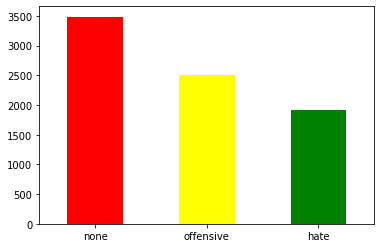

In [15]:
# hate컬럼 분포 비율
colors = ['red', 'yellow', 'green']
CountHate = pd.value_counts(train_data['hate'].values, sort=True)
CountHate.plot.bar('bar', color=colors)
plt.xticks(rotation=0)

In [16]:
# 한글깨짐 해결
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 42 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (4,314 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: fall

In [17]:
# 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rc('font', family = 'NanumGothic')
plt.rc('axes', unicode_minus=False)

## 가설 : 댓글 길이가 길수록 악성댓글일까?
- 댓글 길이에 따라서 일반댓글과 악성댓글의 차이가 있는지 분석
- 차이가 있다면 어떻게 차이가 있는지 시각화

In [18]:
# 시각화에 사용할 데이터
df_hate = train_data[train_data['hate'] == 'hate']
df_hate.reset_index(drop=True, inplace=True)

df_offensive = train_data[train_data['hate'] == 'offensive']
df_offensive.reset_index(drop=True, inplace=True)

df_malicious_comments = pd.concat([df_hate, df_offensive])
df_malicious_comments.reset_index(drop=True, inplace=True)

df_none = train_data[train_data['hate'] == 'none']
df_none.reset_index(drop=True, inplace=True)

<Figure size 432x288 with 0 Axes>

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52404 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45843 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_

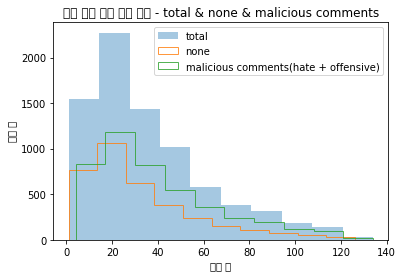

<Figure size 432x288 with 0 Axes>

In [19]:
# 전체 기준으로 악성댓글의 길이 확인
plt.title('전체 기준 댓글 길이 비교 - total & none & malicious comments')
plt.hist(train_data['comments'].str.len(), alpha=0.4, histtype='bar', label='total')
plt.hist(df_none['comments'].str.len(), alpha=0.8, histtype='step', label='none')
plt.hist(df_malicious_comments['comments'].str.len(), alpha=0.8, histtype='step', label='malicious comments(hate + offensive)')
plt.legend()
plt.xlabel('글자 수')
plt.ylabel('빈도 수')
plt.figure()

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50501 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45843 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44544 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44600 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_

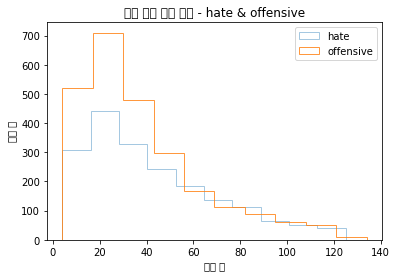

<Figure size 432x288 with 0 Axes>

In [20]:
plt.title('악성 댓글 길이 비교 - hate & offensive')
plt.hist(df_hate['comments'].str.len(), alpha=0.4, histtype='step', label='hate')
plt.hist(df_offensive['comments'].str.len(), alpha=0.8, histtype='step', label='offensive')
plt.legend()
plt.xlabel('글자 수')
plt.ylabel('빈도 수')
plt.figure()

◼ **가설 검정 시각화 결과**
- 전체 기준으로 대부분의 댓글 길이는 40자 내외이다.
- 20자 미만일 때는 일반 댓글(none)이 악성댓글(malicious comments)보다 많다.
-  20자 이상일 때는 일반 댓글(none)보다 악성댓글(malicious comments)이 많다.
- 악성댓글 중 hate와 offensive를 보면, hate보다 offensive 댓글이 더 많다.

# **3. 딥러닝 방식 적용**

### **BERT-Base Multilingual Cased** 모델(여러 국가 언어가 적용된 pretrained model)
1. hate 컬럼을 0과 1로 이진 분류
- none => 0
- offensive, hate => 1

In [21]:
# train데이터의 hate 컬럼을 0, 1로 매칭
train_data.loc[train_data['hate'] != 'none', 'hate'] = 1
train_data.loc[train_data['hate'] == 'none', 'hate'] = 0
train_data.head()

,comments,hate
0,현재 호텔주인 심정 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속 추모받네,1
1,한국적인 미인의 대표적인 분너무나 곱고아름다운모습그모습뒤의 슬픔을 미처 알지못했네요ㅠ,0
2,못된 넘들남의 고통을 즐겼던 넘들이젠 마땅한 처벌을 받아야지그래야 공정한 사회지심은...,1
3,12화 어설펐는데 34화 지나서부터는 갈수록 너무 재밌던데,0
4,1 사람 얼굴 손톱으로 긁은것은 인격살해이고2 동영상이 몰카냐 메걸리안들 생각이 없노,1


In [22]:
# valid데이터의 hate 컬럼을 0, 1로 매칭
valid_data.loc[valid_data['hate'] != 'none', 'hate'] = 1
valid_data.loc[valid_data['hate'] == 'none', 'hate'] = 0
valid_data.head()

,comments,hate
0,송중기 시대극은 믿고본다 첫회 신선하고 좋았다,0
1,지현우 나쁜놈,1
2,알바쓰고많이만들면되지 돈욕심없으면골목식당왜나온겨 기댕기게나하고 산에가서팔어라,1
3,설마 ㅈ 현정 작가 아니지,1
4,이미자씨 송혜교씨 돈이 그리 많으면 탈세말고 그돈으로 평소에 불우이웃에게 기부도 좀...,1


In [23]:
tf.random.set_seed(1)
np.random.seed(1)

BATCH_SIZE = 16
NUM_EPOCHS = 5
VALID_SPLIT = 0.2
MAX_LENGTH = 20

2. 토큰화
- BERT ( Bidirectional Encoder Representations from Transformers ) : Google 에서 개발한 자연어 처리 (NLP) 사전 훈련 을 위한 변환기 기반 기계 학습 기술
- bert_tokenizer() : BERT를 사용하기 위해서 BERT 문장 전처리 함수. BERT를 사용하기 위해 input_ids, attention_mask, token_type_ids가 필요
- input_ids : 문장을 인덱스 값으로 변환
- attention_mask : 문장에서 패딩 부분이 어디인지 알려줌
- token_type_ids : 여러 문장이 들어 갔을 때 이를 구분하기 위함이다. [0 0 0 0 1 1 1 1 0 0 0 0] 이런 경우 총 3문장임을 알 수 있음

In [24]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', cache_dir='bert-ckpt', do_lower_case=False)

def bert_tokenizer(sentence, MAX_LENGTH):
  # encode_plus: 필요한 입력 형태로 변환 및 문장 최대 길이 맞추는 역할. 딕셔너리 형태로 출력
  encoded_dict = tokenizer.encode_plus(
      text = sentence,
      add_special_tokens = True,          # 토큰 시작점과 마지막 지점에 각 각 [CLS], [SEP] 토큰 생성
      max_length = MAX_LENGTH,            # 문장을 최대 길이 MAX_LENGTH에 맞춤
      pad_to_max_length = True,           # 문장이 최대 길이 MAX_LENGTH보다 짧은 경우 패딩 적용
      return_attention_mask = True        # 어텐션 마스크 생성
  )
  
  input_id = encoded_dict['input_ids']
  attention_mask = encoded_dict['attention_mask']
  token_type_id = encoded_dict['token_type_ids']

  return input_id, attention_mask, token_type_id

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [25]:
input_ids = []
attention_masks = []
token_type_ids = []
# train_data_labels = []
train_labels_multilingual = []

for train_sentence, train_label in tqdm(zip(train_data['comments'], train_data['hate']), total=len(train_data)):
  try:
    input_id, attention_mask, token_type_id = bert_tokenizer(train_sentence, MAX_LENGTH)

    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)
    train_labels_multilingual.append(train_label)
  except Exception as e:
    print(e)
    pass

train_hate_input_ids = np.array(input_ids, dtype=int)
train_hate_attention_masks = np.array(attention_masks, dtype=int)
train_hate_token_type_ids = np.array(token_type_ids, dtype=int)
# train_hate_inputs = (train_hate_input_ids, train_hate_attention_masks, train_hate_token_type_ids)
# train_data_labels = np.asarray(train_data_labels, dtype=np.int32)

# print("Sentences:{}\nLabels:{}".format(len(train_hate_input_ids), len(train_data_labels)))
train_inputs_multilingual = (train_hate_input_ids, train_hate_attention_masks, train_hate_token_type_ids)
train_labels_multilingual = np.asarray(train_labels_multilingual, dtype=np.int32)

print("Sentences:{}\nLabels:{}".format(len(train_inputs_multilingual), len(train_labels_multilingual)))

  0%|          | 0/7896 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 7896/7896 [00:05<00:00, 1369.93it/s]

Sentences:3
Labels:7896


In [26]:
input_ids = []
attention_masks = []
token_type_ids = []
# train_data_labels = []
valid_labels_multilingual = []

for valid_sentence, valid_label in tqdm(zip(valid_data['comments'], valid_data['hate']), total=len(valid_data)):
  try:
    input_id, attention_mask, token_type_id = bert_tokenizer(valid_sentence, MAX_LENGTH)

    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)
    valid_labels_multilingual.append(valid_label)
  except Exception as e:
    print(e)
    pass

valid_hate_input_ids = np.array(input_ids, dtype=int)
valid_hate_attention_masks = np.array(attention_masks, dtype=int)
valid_hate_token_type_ids = np.array(token_type_ids, dtype=int)
valid_inputs_multilingual = (valid_hate_input_ids, valid_hate_attention_masks, valid_hate_token_type_ids)
valid_labels_multilingual = np.asarray(valid_labels_multilingual, dtype=np.int32)

print("Sentences:{}\nLabels:{}".format(len(valid_inputs_multilingual), len(valid_labels_multilingual)))

  0%|          | 0/471 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 471/471 [00:00<00:00, 1228.11it/s]

Sentences:3
Labels:471


In [27]:
# input_id, attention_mask, token_type_id 형태 확인
idx = 10

input_id = train_hate_input_ids[idx]
attention_mask = train_hate_attention_masks[idx]
token_type_id = train_hate_token_type_ids[idx]

print("input_id: ", input_id)
print("attention_mask: ", attention_mask)
print("token_type_id: ", token_type_id)
print("tokenizer.decode(input_id): ", tokenizer.decode(input_id))

input_id:  [   101  10150 106249   9730  57362   9008  10622 119353  28911   9365
  14646  59894   9294  50472   8996  24974  12030  12508   8931    102]
attention_mask:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
token_type_id:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
tokenizer.decode(input_id):  [CLS] 10살 차이가 넘을텐데 부부라고 무슨 내용인지 긍 [SEP]


3. 모델링

In [28]:
# Pre-trained model 불러오기
class TFBertClassifier(tf.keras.Model):
  def __init__(self, model_name, dir_path, num_class):
    super(TFBertClassifier, self).__init__()
    self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
    self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
    self.classifier = tf.keras.layers.Dense(num_class,
                                            kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range),
                                            name='classifier')
    
  def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
    outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
    pooled_output = outputs[1]
    pooled_output = self.dropout(pooled_output, training=training)
    logits = self.classifier(pooled_output)

    return logits

multilingual_model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                             dir_path='bert-ckpt',
                             num_class=2)

Downloading:   0%|          | 0.00/1.01G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [29]:
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
multilingual_model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=[metric])

4. 모델 학습

In [30]:
model_name = 'multilingual_hate_speech'

es_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=5)

checkpoint_path = os.path.join('./', model_name, 'weights{epoch:04d}.ckpt')
checkpoint_dir = os.path.dirname(checkpoint_path)
latest = tf.train.latest_checkpoint(checkpoint_dir)

if os.path.exists(checkpoint_dir):
  print('{} Directory already exists.\n'.format(checkpoint_dir))
else:
  os.makedirs(checkpoint_dir, exist_ok=True)  
  print('{} Directory create completes.\n'.format(checkpoint_dir))

cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1,
                              save_best_only=True, save_weights_only=True)

history_multilingual = multilingual_model.fit(train_inputs_multilingual, train_labels_multilingual,
                        batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data = (valid_inputs_multilingual, valid_labels_multilingual),
                        callbacks=[es_callback, cp_callback])
print(history_multilingual.history)

./multilingual_hate_speech Directory create completes.

Epoch 1/5
494/494 [==============================] - ETA: 0s - loss: 0.6358 - accuracy: 0.6384
Epoch 1: val_accuracy improved from -inf to 0.74522, saving model to ./multilingual_hate_speech/weights0001.ckpt
494/494 [==============================] - 95s 156ms/step - loss: 0.6358 - accuracy: 0.6384 - val_loss: 0.5334 - val_accuracy: 0.7452
Epoch 2/5
494/494 [==============================] - ETA: 0s - loss: 0.5386 - accuracy: 0.7344
Epoch 2: val_accuracy did not improve from 0.74522
494/494 [==============================] - 67s 135ms/step - loss: 0.5386 - accuracy: 0.7344 - val_loss: 0.6267 - val_accuracy: 0.6921
Epoch 3/5
494/494 [==============================] - ETA: 0s - loss: 0.4332 - accuracy: 0.8061
Epoch 3: val_accuracy did not improve from 0.74522
494/494 [==============================] - 75s 151ms/step - loss: 0.4332 - accuracy: 0.8061 - val_loss: 0.7216 - val_accuracy: 0.6985
Epoch 4/5
494/494 [=======================

In [31]:
valid_predict_multilingual = multilingual_model.predict(valid_inputs_multilingual, batch_size=32)
predict_labels_multilingual = np.argmax(valid_predict_multilingual, axis=1)

5. 모델 검증

In [32]:
# 모델 검증
print('val accuracy :', accuracy_score(valid_labels_multilingual, predict_labels_multilingual))
print('val f1_score :', f1_score(valid_labels_multilingual, predict_labels_multilingual))

val accuracy : 0.7239915074309978
val f1_score : 0.7750865051903113


In [33]:
print(classification_report(valid_labels_multilingual, predict_labels_multilingual))

              precision    recall  f1-score   support

           0       0.57      0.73      0.64       160
           1       0.84      0.72      0.78       311

    accuracy                           0.72       471
   macro avg       0.71      0.73      0.71       471
weighted avg       0.75      0.72      0.73       471



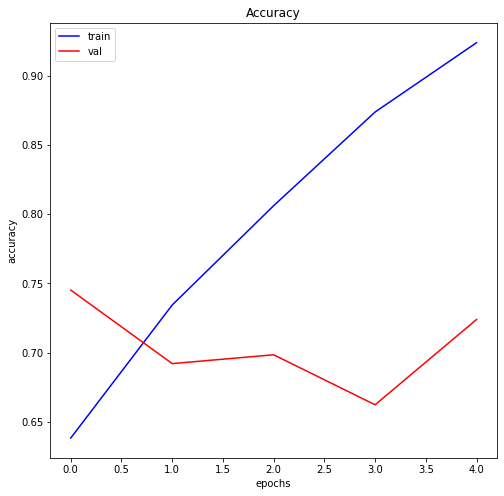

In [45]:
def show_history(model_hist):
  plt.figure(figsize=(8, 8))
  plt.plot(model_hist.history['accuracy'], 'b', label='train')
  plt.plot(model_hist.history['val_accuracy'], 'r', label='val')
  plt.title('Accuracy')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.legend(loc='upper left')

  plt.show();

show_history(history_multilingual)

6. 모델 저장

In [34]:
multilingual_loaded_model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                             dir_path='bert-ckpt',
                             num_class=2)

checkpoint_path = '/content/multilingual_hate_speech'
latest = tf.train.latest_checkpoint('/content/multilingual_hate_speech')

multilingual_loaded_model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=[metric])

multilingual_loaded_model.load_weights(latest)

multilingual_loaded_model.fit(train_inputs_multilingual, train_labels_multilingual,
                        epochs=2, batch_size=BATCH_SIZE, validation_split=VALID_SPLIT)

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2
395/395 [==============================] - 73s 148ms/step - loss: 0.5499 - accuracy: 0.7195 - val_loss: 0.4851 - val_accuracy: 0.7557
Epoch 2/2
395/395 [==============================] - 55s 140ms/step - loss: 0.4369 - accuracy: 0.8045 - val_loss: 0.5515 - val_accuracy: 0.7551


7. test 데이터로 예측

In [35]:
input_ids = []
attention_masks = []
token_type_ids = []
test_data_labels = []

for test_sentence in tqdm(test_data['comments']):
  try:
    input_id, attention_mask, token_type_id = bert_tokenizer(test_sentence, MAX_LENGTH)

    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)
  except Exception as e:
    print(e)
    pass

test_hate_input_ids = np.array(input_ids, dtype=int)
test_hate_attention_masks = np.array(attention_masks, dtype=int)
test_hate_token_type_ids = np.array(token_type_ids, dtype=int)
test_inputs_multilingual = (test_hate_input_ids, test_hate_attention_masks, test_hate_token_type_ids)

  0%|          | 0/974 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 974/974 [00:00<00:00, 3277.50it/s]


In [37]:
test_predict_multilingual = multilingual_model.predict(test_inputs_multilingual, batch_size=32)

In [38]:
predict_labels_multilingual = np.argmax(test_predict_multilingual, axis=1)

8. 모델 결과

In [39]:
result = pd.DataFrame(index=range(0, 974), columns=['Comment', 'multilingual_model'])
for i in range(974):
  result.iloc[i, 0] = test_data['comments'].iloc[i]
  result.iloc[i, 1] = predict_labels_multilingual[i]

In [43]:
pd.set_option('display.max_colwidth', -1)
result

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,Comment,multilingual_model
0,ㅋㅋ 그래도 조아해주는 팬들 많아서 좋겠다 ㅠㅠ 니들은 온유가 안만져줌 ㅠㅠ,1
1,둘다 넘 좋다행복하세요,0
2,근데 만원이하는 현금결제만 하라고 써놓은집 우리나라에 엄청 많은데,0
3,원곡생각하나도 안나고 러블리즈 신곡나온줄 너무 예쁘게 잘봤어요,0
4,장현승 얘도 참 이젠 짠하다,1
...,...,...
969,대박 게스트 꼭 봐야징 컨셉이 바뀌니깐 재미지넹,0
970,성형으로 다 뜯어고쳐놓고 예쁜척 성형 전 니 얼굴 다 알고있다 순자처럼 된장냄새나게 생겼더만,1
971,분위기는 비슷하다만 전혀다른 전개던데 무슨ㅋㅋㄱ 우리나라사람들은 분위기만 비슷하면 다 표절이래 그럼 클래식계열도 다 표절이고 재즈계열도 다 표절이게,0
972,입에 손가릭이 10개 있으니 징그럽다,1
